## Setup

In [1]:
%matplotlib inline
from IPython.display import display

import warnings
warnings.simplefilter(action = "ignore")

# External modules
import os
import pandas as pd
import numpy as np
from sklearn import preprocessing

In [2]:
# Path management
from pathlib import Path

# Get main project directory 
main_dir = str(Path(os.path.abspath('')).parents[0])
os.chdir(main_dir)
print('main dir:',main_dir)

main dir: /Users/pablo/github/isuelogit


In [3]:
# Internal modules
import isuelogit as isl

In [4]:
# Global parameters for experiments
_BILEVEL_ITERS = 10
_REPLICATES = 100
_ALPHA = 0.1
_RANGE_INITIAL_VALUES = (-2,2)
_SD_X = 0.1
_ETA_NGD = 5e-1
_SCALE_OD = 1
_N_SPARSE_FEATURES = 6
_SEED = 2022
_SHOW_REPLICATE_PLOT = False
_REPLICATE_REPORT = False

In [5]:
# List of experiments
list_experiments  = ['pseudoconvexity', 'convergence','congestion','consistency', 'irrelevant_attributes',
                     'noisy_counts','sensor_coverage','noisy_od','ill_scaled_od']

run_experiment = dict.fromkeys(list_experiments,True)
#run_experiment = dict.fromkeys(list_experiments,False)
#run_experiment['irrelevant_attributes'] = True

## Read network data from tntp repository

In [6]:
network_name = 'SiouxFalls'

# Read input data files
links_df = isl.reader.read_tntp_linkdata(network_name= network_name, folderpath = os.getcwd() + "/input/tntp/")

# Add link key
links_df['link_key'] = [(i, j, '0') for i, j in zip(links_df['init_node'], links_df['term_node'])]

## Build network

In [7]:
network_generator = isl.factory.NetworkGenerator()

A = network_generator.generate_adjacency_matrix(links_keys = list(links_df['link_key'].values))

tntp_network = network_generator.build_network(A = A,network_name= network_name)


Creating SiouxFalls network

Nodes: 24, Links: 76


### Exogenous link attributes

In [8]:
# Extract data on link features
link_features_df = links_df[['link_key', 'speed', 'toll', 'link_type']]

#Load features data
tntp_network.load_features_data(linkdata = link_features_df)

### Link performance functions

In [9]:
# Create BPR functions among links using parameters read from TNTP file
bpr_parameters_df = pd.DataFrame({'link_key': tntp_network.links_dict.keys(),
                                  'alpha': 2.5, #links_df.b
                                  'beta': links_df.power,
                                  'tf': links_df.free_flow_time,
                                  'k': links_df.capacity
                                  })

# Normalize free flow travel time between 0 and 1
bpr_parameters_df['tf'] = pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(np.array(bpr_parameters_df['tf']).reshape(-1, 1)))

tntp_network.set_bpr_functions(bprdata = bpr_parameters_df)

### OD matrix

In [10]:
# Read od matrix
Q = isl.reader.read_tntp_od(network_name= network_name, folderpath = os.getcwd() + "/input/tntp/")

# Load O-D matrix
tntp_network.load_OD(Q  = Q)

Reading Q from external file
Matrix Q (24, 24) read in 0.4[s]                        

360600.0 trips were loaded among 528 o-d pairs


### Paths

In [11]:
# Create path generator
paths_generator = isl.factory.PathsGenerator()

# Generate and Load paths in network
paths_generator.load_k_shortest_paths(network = tntp_network, k=2)

Generating at most 2 paths per od
1056 paths were generated among 528 od pairs in 0.5 [s]

1056 paths were loaded in the network

Updating incidence matrices

Matrix D (76, 1056) generated in 0.9[s]               

Matrix M (528, 1056) generated in 0.2[s]               

Matrix C (1056, 1056) generated in 0.0[s]               



### Utility Function

In [12]:
utility_function = isl.estimation.UtilityFunction(features_Y=['tt'],
                                                  features_Z=['c', 's'],
                                                  true_values={'tt': -1, 'c': -6, 's': -3})

## Descriptive statistics

### Network topology

In [13]:
isl.descriptive_statistics.summary_table_networks([tntp_network])

,network,nodes,links,ods,paths
0,SiouxFalls,24,76,528,1056


### Links data

In [14]:
display(tntp_network.Z_data)

,link_type,speed,toll,alpha,beta,tf,k
0,1,0,0,2.5,4.0,0.500,25900.200640
1,1,0,0,2.5,4.0,0.250,23403.473190
2,1,0,0,2.5,4.0,0.500,25900.200640
3,1,0,0,2.5,4.0,0.375,4958.180928
4,1,0,0,2.5,4.0,0.250,23403.473190
...,...,...,...,...,...,...,...
71,1,0,0,2.5,4.0,0.250,5000.000000
72,1,0,0,2.5,4.0,0.000,5078.508436
73,1,0,0,2.5,4.0,0.250,5091.256152
74,1,0,0,2.5,4.0,0.125,4885.357564


In [15]:
tntp_network.Z_data.describe()

,link_type,speed,toll,alpha,beta,tf,k
count,76.0,76.0,76.0,76.0,76.0,76.000000,76.000000
mean,1.0,0.0,0.0,2.5,4.0,0.266447,10247.206327
std,0.0,0.0,0.0,0.0,0.0,0.216354,7358.655049
min,1.0,0.0,0.0,2.5,4.0,0.000000,4823.950831
25%,1.0,0.0,0.0,2.5,4.0,0.125000,4958.180928
50%,1.0,0.0,0.0,2.5,4.0,0.250000,5109.391136
75%,1.0,0.0,0.0,2.5,4.0,0.375000,14564.753150
max,1.0,0.0,0.0,2.5,4.0,1.000000,25900.200640


## Experiments

### a) Pseudoconvexity


Generating synthetic link counts via Frank-Wolfe

SUE via fw (max iters: 100)

Equilibrium gaps: ['1E-01', '4E-02', '4E-02', '2E-02', '2E-02', '1E-02', '2E-02', '8E-03', '4E-03', '4E-03', '3E-03', '2E-03', '2E-03', '1E-03', '5E-03', '3E-03', '9E-04', '4E-04', '6E-04', '3E-04', '7E-04', '3E-04', '5E-04', '3E-04', '3E-04', '1E-04', '2E-04', '1E-04', '3E-04', '3E-04', '8E-05', '6E-05', '6E-05', '5E-05', '5E-05', '5E-05', '4E-05', '4E-05', '3E-05', '4E-05', '3E-05', '4E-05', '3E-05', '2E-05', '2E-05', '2E-05', '2E-05', '1E-05', '2E-05', '1E-05', '1E-05', '9E-06', '1E-05', '7E-06', '1E-05', '7E-06', '3E-05', '2E-05', '4E-06', '7E-06', '2E-06', '7E-06', '9E-06', '1E-06', '5E-06', '3E-06', '3E-06', '4E-06', '6E-07', '1E-05', '1E-06', '2E-07', '0E+00']
Initial Fisk Objective: -38,646,347.22
Final Fisk Objective: -7,771,704.52
Improvement Fisk Objective: 79.89%
Final gap: 0E+00. Acc. bound: 1E-10. Time: 7.5 [s]
Ratio of counts versus capacity: 108.7%
Proportion of links over capacity: 71.1%
No

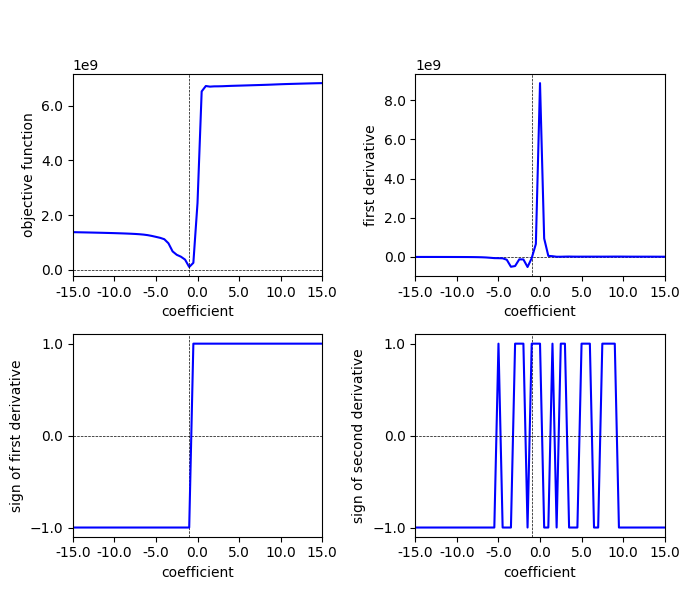


Performing grid search for c



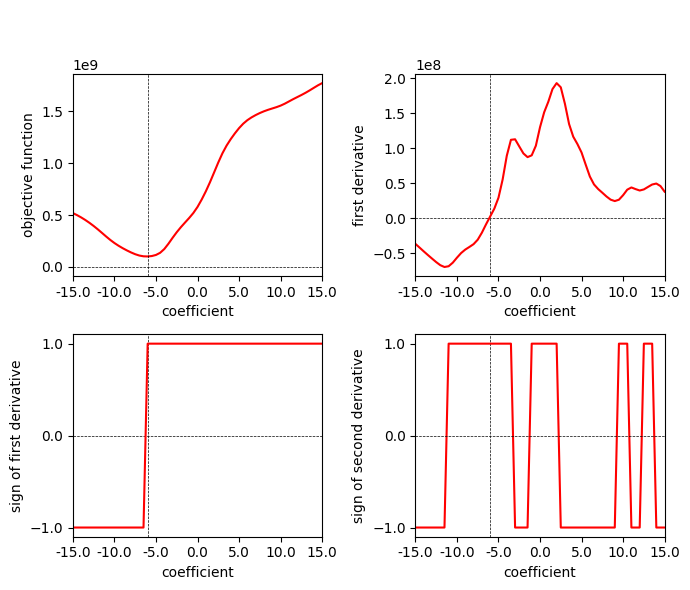

Coordinate-wise pseudo-convexity


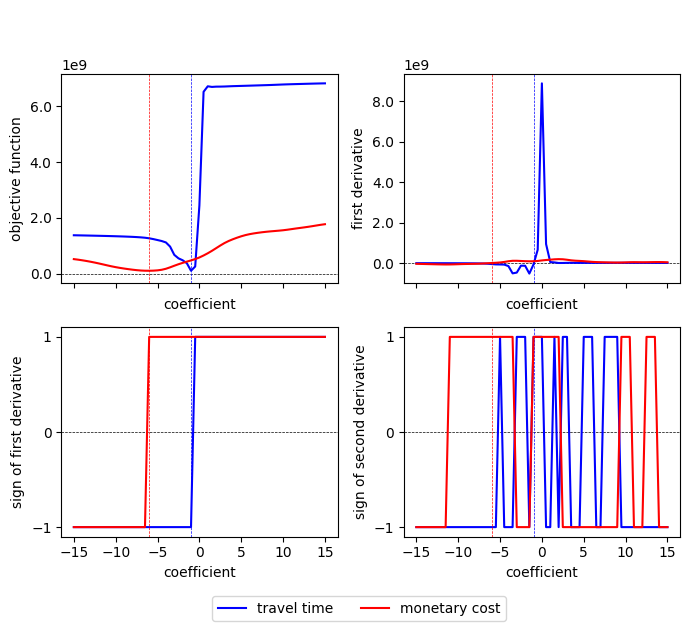

In [16]:
if run_experiment['pseudoconvexity']:

    equilibrator_pseudoconvexity = isl.equilibrium.LUE_Equilibrator(
        network = tntp_network,
        max_iters=100,
        method='fw',
        iters_fw=100,
        accuracy=1e-10,
        exogenous_traveltimes=True,
        paths_generator=paths_generator)

    pseudoconvexity_experiment = isl.experiments.PseudoconvexityExperiment(
        seed=_SEED,
        name='Pseudo-convexity Experiment',
        folderpath=isl.config.dirs['output_folder'] + 'experiments/' + network_name,
        utility_function=utility_function,
        linkdata_generator=isl.factory.LinkDataGenerator(noise_params={'sd_x': _SD_X}),
        equilibrator= equilibrator_pseudoconvexity,
        network=tntp_network)

    # Generate new random features ('c,'s') and load them in the network
    tntp_network.load_features_data(linkdata=pseudoconvexity_experiment.generate_random_link_features(n_sparse_features=0))

    pseudoconvexity_experiment.run(grid = np.arange(-15, 15+0.1, 0.5),
                                   xticks=np.arange(-15, 15 + 0.1, 5),
                                   features=['tt', 'c'],
                                   features_labels = ['travel time', 'monetary cost'],
                                   colors = ['blue','red']
                                   )

### b) Convergence


Convergence Experiment

Scenario: exogenous

Generating synthetic link counts via Frank-Wolfe

SUE via fw (max iters: 100)

Equilibrium gaps: ['1E-01', '4E-02', '4E-02', '2E-02', '2E-02', '1E-02', '2E-02', '8E-03', '4E-03', '4E-03', '3E-03', '2E-03', '2E-03', '1E-03', '5E-03', '3E-03', '9E-04', '4E-04', '6E-04', '3E-04', '7E-04', '3E-04', '5E-04', '3E-04', '3E-04', '1E-04', '2E-04', '1E-04', '3E-04', '3E-04', '8E-05', '6E-05', '6E-05', '5E-05', '5E-05', '5E-05', '4E-05', '4E-05', '3E-05', '4E-05', '3E-05', '4E-05', '3E-05', '2E-05', '2E-05', '2E-05', '2E-05', '1E-05', '2E-05', '1E-05', '1E-05', '9E-06', '1E-05', '7E-06', '1E-05', '7E-06', '3E-05', '2E-05', '4E-06', '7E-06', '2E-06', '7E-06', '9E-06', '1E-06', '5E-06', '3E-06', '3E-06', '4E-06', '6E-07', '1E-05', '1E-06', '2E-07', '0E+00']
Initial Fisk Objective: -38,646,347.22
Final Fisk Objective: -7,771,704.52
Improvement Fisk Objective: 79.89%
Final gap: 0E+00. Acc. bound: 1E-10. Time: 9.4 [s]
Ratio of counts versus capacity: 108.7

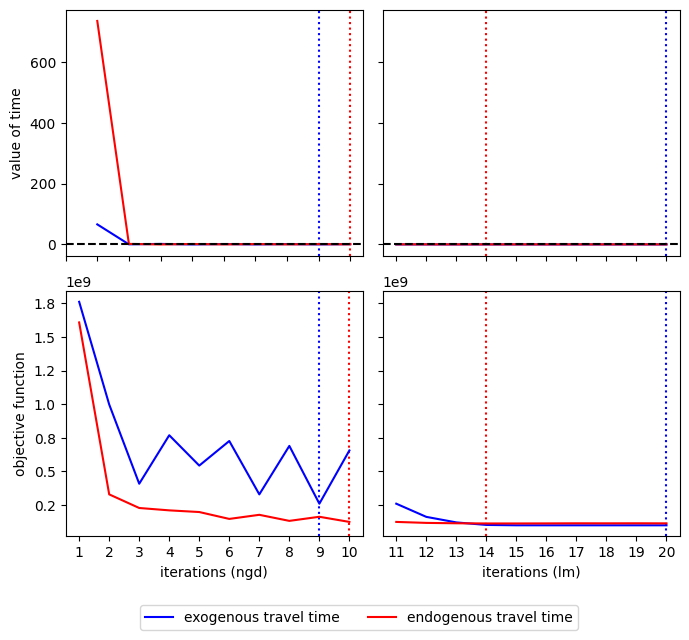

In [17]:
if run_experiment['convergence']:

    equilibrator_convergence = isl.equilibrium.LUE_Equilibrator(
            network = tntp_network,
            max_iters=100,
            method='fw',
            iters_fw=100,
            accuracy=1e-10,
            paths_generator=paths_generator)

    outer_optimizer_norefined = isl.estimation.OuterOptimizer(
        method='ngd',
        iters=1,
        eta=_ETA_NGD
    )

    outer_optimizer_refined = isl.estimation.OuterOptimizer(
        method='lm',
        iters=1,
    )

    convergence_experiment = isl.experiments.ConvergenceExperiment(
        seed=_SEED,
        name='Convergence Experiment',
        folderpath=isl.config.dirs['output_folder'] + 'experiments/' + network_name,
        outer_optimizers=[outer_optimizer_norefined, outer_optimizer_refined],
        utility_function=utility_function,
        linkdata_generator=isl.factory.LinkDataGenerator(noise_params={'sd_x': _SD_X}),
        equilibrator = equilibrator_convergence,
        bilevel_iters=_BILEVEL_ITERS,
        network=tntp_network)

    tntp_network.load_features_data(
        linkdata=convergence_experiment.generate_random_link_features(
        n_sparse_features=0))

    convergence_experiment.run(range_initial_values = None, replicate_report = False)

### c) Consistency


Consistency Experiment (endogenous travel time)
Replicates: |####################| 100/100 


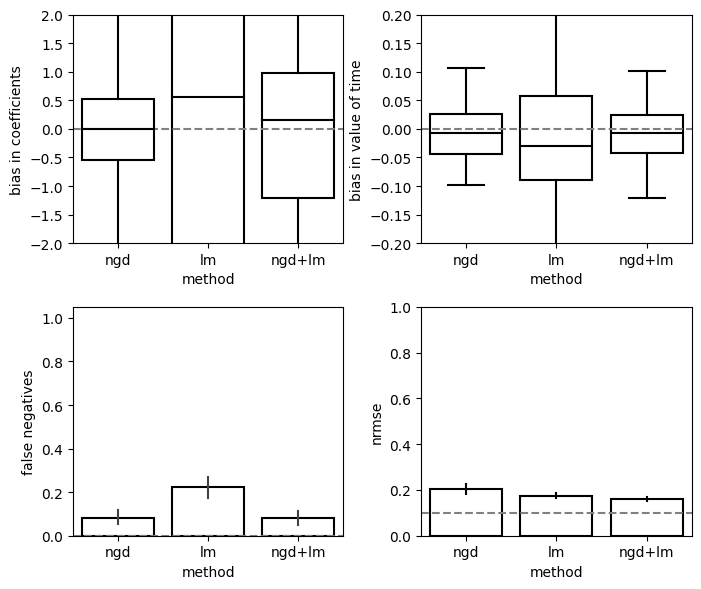


Consistency Experiment (exogenous travel time)
Replicates: |####################| 100/100 


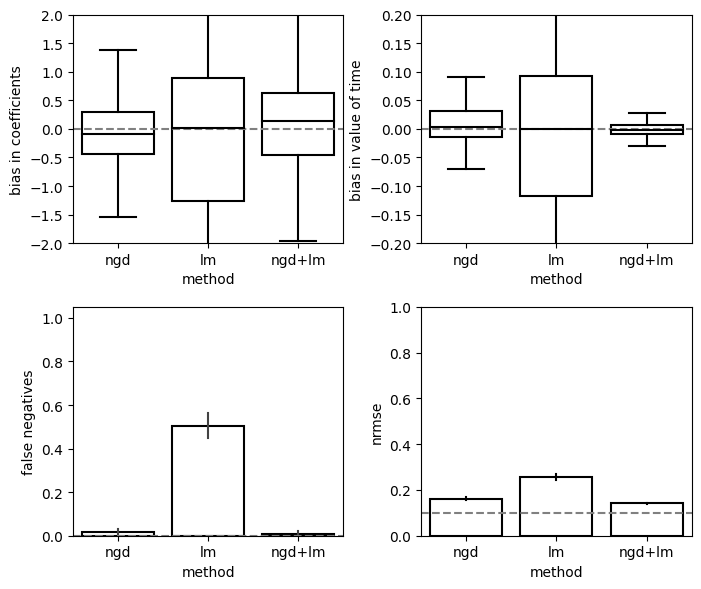

In [18]:
if run_experiment['consistency']:

    outer_optimizer_no_refined = isl.estimation.OuterOptimizer(
        method='ngd',
        iters=1,
        eta= _ETA_NGD
    )

    outer_optimizer_refined_1 = isl.estimation.OuterOptimizer(
        method='lm',
        iters=1
    )

    outer_optimizer_refined_2 = isl.estimation.OuterOptimizer(
        method='lm',
        iters=1
    )

    # i) Endogenous travel times

    equilibrator_endogenous_traveltimes = isl.equilibrium.LUE_Equilibrator(
        network = tntp_network,
        max_iters=100,
        method='fw',
        iters_fw=100,
        accuracy=1e-10,
        exogenous_traveltimes=False,
        paths_generator=paths_generator,
    )

    consistency_experiment_endogenous_traveltimes = isl.experiments.ConsistencyExperiment(
        seed=_SEED,
        name='Consistency Experiment (endogenous travel time)',
        folderpath=isl.config.dirs['output_folder'] + 'experiments/' + network_name,
        equilibrator=equilibrator_endogenous_traveltimes,
        outer_optimizers=[outer_optimizer_no_refined,
                          outer_optimizer_refined_1,
                          outer_optimizer_refined_2],
        utility_function=utility_function,
        linkdata_generator=isl.factory.LinkDataGenerator(noise_params={'sd_x': _SD_X}),
        network=tntp_network)

    consistency_experiment_endogenous_traveltimes.run(
        bilevel_iters = _BILEVEL_ITERS,
        range_initial_values = _RANGE_INITIAL_VALUES,
        replicates = _REPLICATES,
        n_sparse_features=0*_N_SPARSE_FEATURES,
        show_replicate_plot=_SHOW_REPLICATE_PLOT,
        replicate_report = False,
        alpha = _ALPHA
    )

    # ii) Exogenous travel times

    equilibrator_exogenous_traveltimes = isl.equilibrium.LUE_Equilibrator(
        network = tntp_network,
        max_iters=100,
        method='fw',
        iters_fw=100,
        accuracy=1e-10,
        exogenous_traveltimes=True,
        paths_generator=paths_generator,
    )

    consistency_experiment_exogenous_traveltimes = isl.experiments.ConsistencyExperiment(
        seed=_SEED,
        name='Consistency Experiment (exogenous travel time)',
        folderpath=isl.config.dirs['output_folder'] + 'experiments/' + network_name,
        equilibrator=equilibrator_exogenous_traveltimes,
        outer_optimizers=[outer_optimizer_no_refined,
                          outer_optimizer_refined_1,
                          outer_optimizer_refined_2],
        utility_function=utility_function,
        linkdata_generator=isl.factory.LinkDataGenerator(noise_params={'sd_x': _SD_X}),
        network=tntp_network)

    consistency_experiment_exogenous_traveltimes.run(
        bilevel_iters = _BILEVEL_ITERS,
        range_initial_values = _RANGE_INITIAL_VALUES,
        replicates = _REPLICATES,
        n_sparse_features=0*_N_SPARSE_FEATURES,
        show_replicate_plot=_SHOW_REPLICATE_PLOT,
        replicate_report = False,
        alpha = _ALPHA
    )

### d) Inclusion of irrelevant attributes


Irrelevant Attributes Experiment
Replicates: |####################| 100/100 


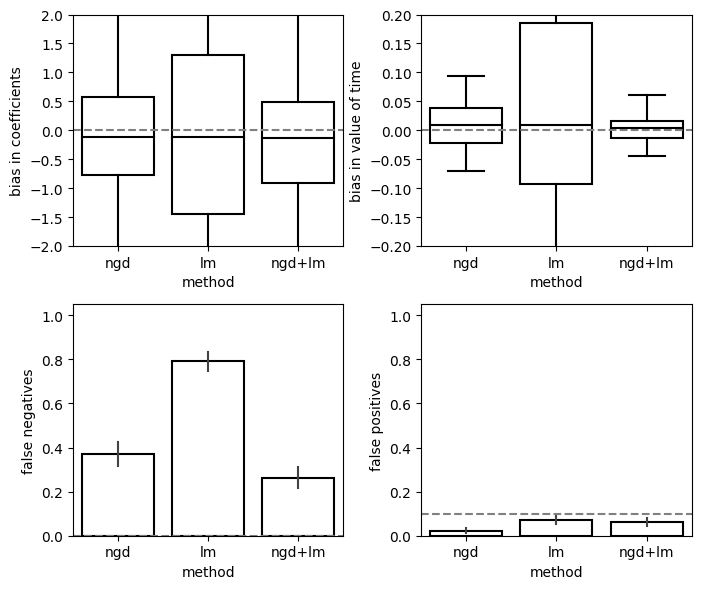

In [19]:
if run_experiment['irrelevant_attributes']:

    outer_optimizer_no_refined = isl.estimation.OuterOptimizer(
        method='ngd',
        iters=1,
        eta=_ETA_NGD
    )

    outer_optimizer_refined_1 = isl.estimation.OuterOptimizer(
        method='lm',
        iters=1
    )

    outer_optimizer_refined_2 = isl.estimation.OuterOptimizer(
        method='lm',
        iters=1
    )

    equilibrator = isl.equilibrium.LUE_Equilibrator(
        network = tntp_network,
        max_iters=100,
        method='fw',
        iters_fw=100,
        accuracy=1e-10,
        exogenous_traveltimes=True,
        paths_generator=paths_generator,
    )

    irrelevant_attributes_experiment = isl.experiments.ConsistencyExperiment(
        seed=_SEED,
        name='Irrelevant Attributes Experiment',
        folderpath=isl.config.dirs['output_folder'] + 'experiments/' + network_name,
        equilibrator=equilibrator,
        outer_optimizers=[outer_optimizer_no_refined,
                          outer_optimizer_refined_1,
                          outer_optimizer_refined_2],
        utility_function=utility_function,
        linkdata_generator=isl.factory.LinkDataGenerator(noise_params={'sd_x': _SD_X}),
        network=tntp_network)

    irrelevant_attributes_experiment.run(
        bilevel_iters=_BILEVEL_ITERS,
        range_initial_values=_RANGE_INITIAL_VALUES,
        replicates=_REPLICATES,
        n_sparse_features=_N_SPARSE_FEATURES,
        show_replicate_plot=_SHOW_REPLICATE_PLOT,
        replicate_report = False,
        alpha=_ALPHA
    )

### e) Error in traffic count measurements


Noisy Counts Experiment
Replicates: |####################| 100/100 


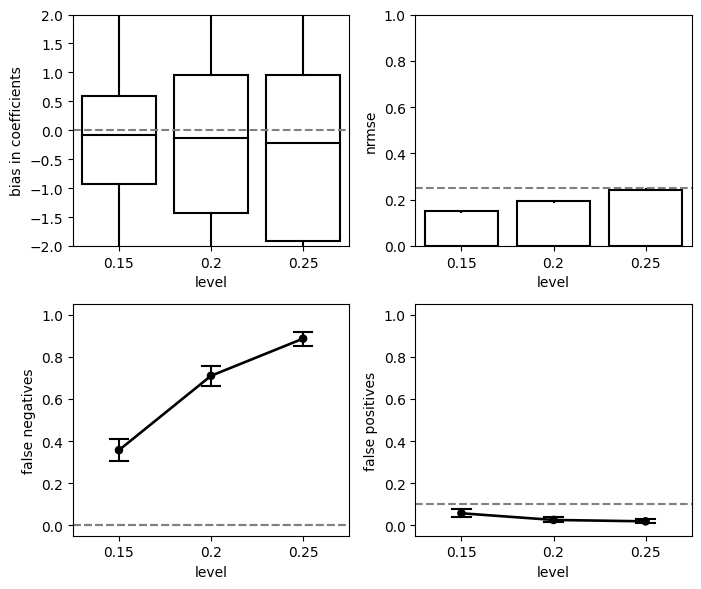

In [20]:
if run_experiment['noisy_counts']:

    outer_optimizer_norefined = isl.estimation.OuterOptimizer(
        method='ngd',
        iters=1,
        eta= _ETA_NGD
    )

    outer_optimizer_refined = isl.estimation.OuterOptimizer(
        iters=1,
        method='lm',
    )

    equilibrator = isl.equilibrium.LUE_Equilibrator(
        network = tntp_network,
        max_iters=100,
        method='fw',
        iters_fw=100,
        accuracy=1e-10,
        exogenous_traveltimes=True,
        paths_generator=paths_generator,
    )

    noisy_counts_experiment = isl.experiments.CountsExperiment(
        seed=_SEED,
        name='Noisy Counts Experiment',
        folderpath=isl.config.dirs['output_folder'] + 'experiments/' + network_name,
        outer_optimizers= [outer_optimizer_norefined, outer_optimizer_refined],
        utility_function=utility_function,
        linkdata_generator=isl.factory.LinkDataGenerator(),
        equilibrator=equilibrator,
        bilevel_iters= _BILEVEL_ITERS,
        network=tntp_network)

    noisy_counts_experiment.run(
        replicates = _REPLICATES,
        range_initial_values = _RANGE_INITIAL_VALUES,
        alpha = _ALPHA,
        n_sparse_features=_N_SPARSE_FEATURES,
        show_replicate_plot=_SHOW_REPLICATE_PLOT,
        levels=[0.15, 0.2, 0.25],
        type = 'noise')

### f) Sensor coverage


Sensor Coverage Experiment
Replicates: |####################| 100/100 


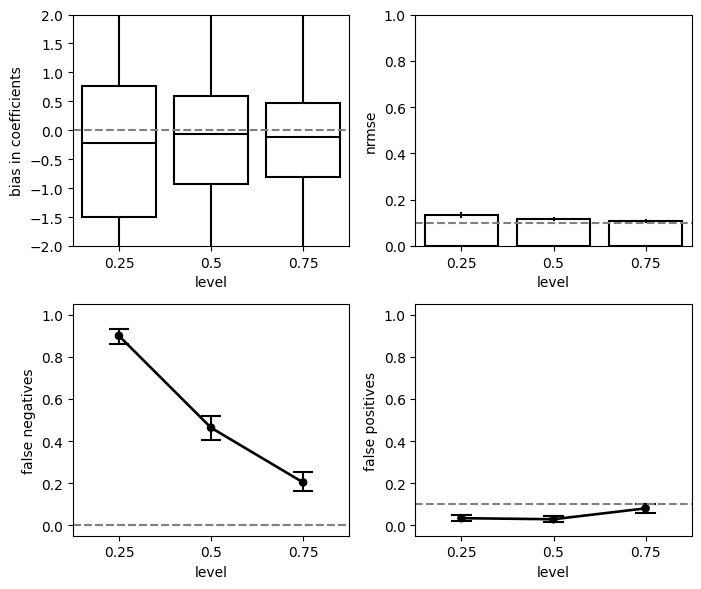

In [21]:
if run_experiment['sensor_coverage']:

    outer_optimizer_norefined = isl.estimation.OuterOptimizer(
        method='ngd',
        iters=1,
        eta= _ETA_NGD
    )

    outer_optimizer_refined = isl.estimation.OuterOptimizer(
        iters=1,
        method='lm',
    )

    equilibrator = isl.equilibrium.LUE_Equilibrator(
        network = tntp_network,
        max_iters=100,
        method='fw',
        iters_fw=100,
        accuracy=1e-10,
        exogenous_traveltimes=True,
        paths_generator=paths_generator,
    )

    sensor_coverage_experiment = isl.experiments.CountsExperiment(
        seed=_SEED,
        name='Sensor Coverage Experiment',
        folderpath=isl.config.dirs['output_folder'] + 'experiments/' + network_name,
        outer_optimizers=[outer_optimizer_norefined, outer_optimizer_refined],
        # outer_optimizers=[outer_optimizer_norefined],
        utility_function=utility_function,
        linkdata_generator=isl.factory.LinkDataGenerator(noise_params={'sd_x': _SD_X}),
        equilibrator=equilibrator,
        bilevel_iters=_BILEVEL_ITERS,
        network=tntp_network)

    sensor_coverage_experiment.run(
        alpha = _ALPHA,
        replicates = _REPLICATES,
        range_initial_values = _RANGE_INITIAL_VALUES,
        n_sparse_features=_N_SPARSE_FEATURES,
        show_replicate_plot=_SHOW_REPLICATE_PLOT,
        replicate_report = False,
        levels=[0.25, 0.5, 0.75],
        type = 'coverage')

### g) Error in OD matrix


Noisy OD Experiment
Replicates: |####################| 100/100 


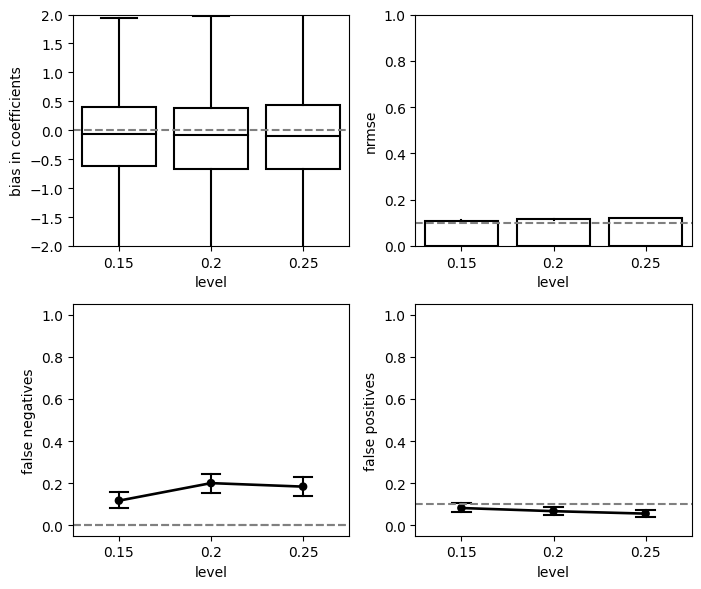

In [22]:
if run_experiment['noisy_od']:

    outer_optimizer_norefined = isl.estimation.OuterOptimizer(
        method='ngd',
        iters=1,
        eta= _ETA_NGD
    )

    outer_optimizer_refined = isl.estimation.OuterOptimizer(
        iters=1,
        method='lm',
    )

    equilibrator = isl.equilibrium.LUE_Equilibrator(
        network = tntp_network,
        max_iters=100,
        method='fw',
        iters_fw=100,
        accuracy=1e-10,
        exogenous_traveltimes=True,
        paths_generator=paths_generator,
    )

    noisy_od_experiment = isl.experiments.ODExperiment(
        seed=_SEED,
        name='Noisy OD Experiment',
        folderpath=isl.config.dirs['output_folder'] + 'experiments/' + network_name,
        outer_optimizers=[outer_optimizer_norefined, outer_optimizer_refined],
        utility_function=utility_function,
        linkdata_generator=isl.factory.LinkDataGenerator(noise_params={'sd_x': _SD_X}),
        equilibrator=equilibrator,
        bilevel_iters=_BILEVEL_ITERS,
        network=tntp_network)

    # Note: Random features ('c,'s') and 3 sparse attributes are generated and loaded in the network at every replicate

    noisy_od_experiment.run(
        replicates = _REPLICATES,
        range_initial_values = _RANGE_INITIAL_VALUES,
        levels=[0.15, 0.2, 0.25],
        alpha=_ALPHA,
        n_sparse_features=_N_SPARSE_FEATURES,
        show_replicate_plot=_SHOW_REPLICATE_PLOT,
        type = 'noise')

### h) Scale of OD matrix


Ill-scaled OD Experiment
Replicates: |####################| 100/100 


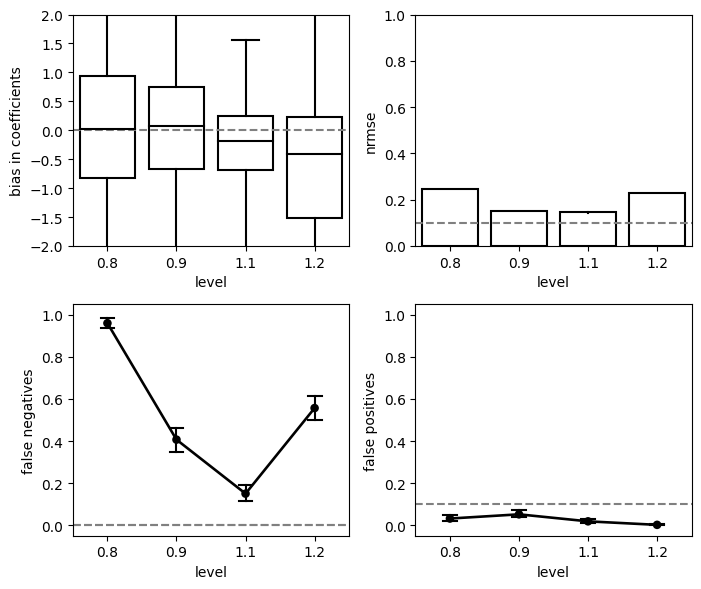

In [23]:
if run_experiment['ill_scaled_od']:

    outer_optimizer_norefined = isl.estimation.OuterOptimizer(
        method='ngd',
        iters=1,
        eta=_ETA_NGD
    )

    outer_optimizer_refined = isl.estimation.OuterOptimizer(
        iters=1,
        method='lm',
    )

    equilibrator = isl.equilibrium.LUE_Equilibrator(
        network = tntp_network,
        max_iters=100,
        method='fw',
        iters_fw=100,
        accuracy=1e-10,
        exogenous_traveltimes=True,
        paths_generator=paths_generator,
    )

    ill_scaled_od_experiment = isl.experiments.ODExperiment(
        seed=_SEED,
        name='Ill-scaled OD Experiment',
        folderpath=isl.config.dirs['output_folder'] + 'experiments/' + network_name,
        outer_optimizers=[outer_optimizer_norefined, outer_optimizer_refined],
        utility_function=utility_function,
        linkdata_generator=isl.factory.LinkDataGenerator(noise_params={'sd_x': _SD_X}),
        equilibrator=equilibrator,
        bilevel_iters=_BILEVEL_ITERS,
        network=tntp_network)

    ill_scaled_od_experiment.run(
        replicates = _REPLICATES,
        range_initial_values = _RANGE_INITIAL_VALUES,
        alpha = _ALPHA,
        n_sparse_features=_N_SPARSE_FEATURES,
        show_replicate_plot=_SHOW_REPLICATE_PLOT,
        levels=[0.8, 0.9, 1.1, 1.2],
        type = 'scale')